# Benchmarking randomized circuits using Quantum state tomography

Easy gate: Paulis
Hard gate: H, CZ
Twiling: Paulis

In [1]:
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import IGate, HGate
import numpy as np

# Code taken from https://quantumcomputing.stackexchange.com/questions/22149/replace-gate-with-known-identity-in-quantum-circuit
class CZOverrotation(TransformationPass):
    def run(self, dag):
        """Run the pass."""

        # iterate over all operations
        for node in dag.op_nodes():
            if node.op.name in ["cx"]:
                # calculate the replacement
                replacement = QuantumCircuit(2)
                angle = np.random.random() * 1.0
                replacement.cp(np.pi + angle, 0, 1)
            elif node.op.name in ["h"]:
                replacement = QuantumCircuit(1)
                angle = 0.1
                random_angle = np.pi + np.random.random() * angle - angle/2
                ugate = UnitaryGate(np.cos(random_angle/2) * IGate().to_matrix() - 1.0j * np.sin(random_angle/2) * HGate().to_matrix())
                replacement.unitary(ugate, 0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))

        return dag

In [2]:
def benchmark_rc_circuit(original_circuit, randomized_circuits, measurement_qubits, backend, dpi=None):
    from qiskit_experiments.library import StateTomography
    from qiskit.quantum_info import DensityMatrix, state_fidelity, Statevector, partial_trace, purity
    from qiskit.visualization.utils import _bloch_multivector_data
    from qiskit.visualization.bloch import Bloch
    from matplotlib import pyplot as plt

    n = original_circuit.num_qubits
    density_matrices = []

    for circ in randomized_circuits:
        qstexp = StateTomography(circ, measurement_qubits=measurement_qubits)
        qstdata = qstexp.run(backend, shots=500).block_for_results()
        density_matrices.append(qstdata.analysis_results('state').value)

    bloch_data = [_bloch_multivector_data(density_matrix) for density_matrix in density_matrices]
    average_dm = DensityMatrix(sum([dm.data for dm in density_matrices]) / len(density_matrices))

    target_state = Statevector.from_instruction(original_circuit)
    target_dm = partial_trace(target_state, [i for i in range(n) if i not in measurement_qubits])
    fidelity_list = [state_fidelity(target_dm, dm) for dm in density_matrices]
    purity_list = [purity(dm) for dm in density_matrices]
    fidelity = state_fidelity(target_dm, average_dm)

    average_vectors = _bloch_multivector_data(average_dm)
    target_vectors = _bloch_multivector_data(target_dm)

    # Source code taken from https://qiskit.org/documentation/_modules/qiskit/visualization/state_visualization.html#plot_bloch_multivector
    num = len(bloch_data[0])
    width, height = plt.figaspect(1 / num)
    fig = plt.figure(figsize=(width, height), dpi=dpi)

    ax_list = [fig.add_subplot(1, num, i + 1, projection="3d") for i in range(num)]
    for i in range(num):
        B = Bloch(axes=ax_list[i])
        B.vector_width = 3
        B.vector_mutation = 5
        B.point_marker = ['o']
        B.point_size = [5]
        B.point_color = ['y']
        for j in range(len(randomized_circuits)):
            B.add_points(bloch_data[j][i], 'm')
        B.add_vectors(average_vectors[i])
        B.add_vectors(target_vectors[i])
        B.render()

    print(f'The blue arrow corresponds to the ideal result.')
    print(f'Fidelity of the red arrow: {fidelity}')
    print(f'Fidelity of the points: {fidelity_list}')
    print(f'Purities of the points: {purity_list}')

    return fig

In [3]:
def tvd_benchmark_rc_circuit(original_circuit, randomized_circuits, backend, shots_per_randomized_circuit = 500):
    from qiskit import execute
    from qiskit.quantum_info import Statevector

    n_random_circs = len(randomized_circuits)
    total_shots = n_random_circs * shots_per_randomized_circuit

    state_vector = Statevector.from_instruction(original_circuit)
    ideal_probabilities = state_vector.probabilities_dict()

    original_circuit_ = original_circuit.copy()
    #original_circuit_ = CZOverrotation()(original_circuit_)
    original_circuit_.measure_all()
    bare_counts = execute(original_circuit_, backend, shots=n_random_circs * shots_per_randomized_circuit).result().get_counts()
    bare_counts = {key: value for key, value in sorted(bare_counts.items())}

    rc_counts_list = []
    for rc in randomized_circuits:
        rc_ = rc.copy()
        #rc_ = CZOverrotation()(rc_)
        rc_.measure_all()
        rc_counts_list.append(execute(rc_, backend, shots=shots_per_randomized_circuit).result().get_counts())
    keys = set().union(*rc_counts_list)
    rc_counts = {k: sum([cnts.get(k, 0) for cnts in rc_counts_list]) for k in keys}
    rc_counts = {key: value for key, value in sorted(rc_counts.items())}

    tvd_bare = sum(0.5 * abs(ideal_probabilities.get(key, 0) - bare_counts.get(key, 0) / total_shots)
                   for key in ideal_probabilities.keys() | bare_counts.keys())
    tvd_random = sum(0.5 * abs(ideal_probabilities.get(key, 0) - rc_counts.get(key, 0) / total_shots)
                     for key in ideal_probabilities.keys() | rc_counts.keys())
    
    tvd_random_set = [abs(ideal_probabilities.get(key, 0) - rc_counts.get(key, 0) / total_shots)
                     for key in ideal_probabilities.keys() | rc_counts.keys()]
    #print(ideal_probabilities)
    #print('Original TVD: ', tvd_bare, bare_counts)
    #print('Randomized TVD: ', tvd_random, rc_counts)
    
    return [tvd_random, tvd_random_set]

In [4]:
def randomized_circuit(q_input, circ_number, max_iter):
    from qiskit.compiler import transpile
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import XGate, YGate, ZGate, IGate
    import numpy as np

    ## define easy and hard gates

    easy_gate = ['id', 'x', 'y', 'z']
    hard_gate = ['cz', 't', 'h', 'cx']
    basis_gate = easy_gate + hard_gate + ['rz']

    ## transpile the input gate to the equivalent gate with easy and hard gates basis

    q_transform = q_input
    # q_transform = transpile(q_input, basis_gates=basis_gate)

    random_circuit_set = []

    ## set easy_layer sets and hard_layer sets
    easy_layer = []
    hard_layer = []
    easy_layer_comp = []
    hard_seeker = False
    for gate in q_transform.data:
        if gate[0].name in hard_gate:
            hard_layer.append(gate)
            hard_seeker=True
            easy_layer.append(easy_layer_comp)
            easy_layer_comp=[]
        elif gate[0].name in easy_gate:
            if hard_seeker:
                hard_seeker=False
                easy_layer_comp=[]
            easy_layer_comp.append(gate)
    easy_layer.append(easy_layer_comp)

    def random_T():
        rand_value = np.random.randint(4)
        if rand_value == 0:
            return XGate()
        elif rand_value == 1:
            return YGate()
        elif rand_value == 2:
            return ZGate()
        else:
            return IGate()

    depth_easy = len(easy_layer)
    depth_hard = len(hard_layer)
    depth = depth_easy + depth_hard

    for _ in np.arange(circ_number):
        T_set = []
        for _ in range(depth_hard):
            T_comp = []
            for _ in np.arange(q_transform.num_qubits):
                T = random_T()
                T_comp.append(T)
            T_set.append(T_comp)

        q_out = QuantumCircuit(q_transform.num_qubits)
        for ind in range(depth//2 + 1):
            # Hard layer
            if ind > 0:
                q_out.barrier()
                q_out.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
                q_out.barrier()
            # Tc + easy + T layer (No Tc at the first layer, no T at the final layer)
            ## Tc
            q_temp = QuantumCircuit(q_transform.num_qubits)
            if ind > 0:
                q_temp.compose(hard_layer[ind - 1][0].reverse_ops(), hard_layer[ind - 1][1], inplace=True)
                for T_ind in np.arange(len(T_set[ind - 1])):
                    q_temp.compose(T_set[ind - 1][T_ind].reverse_ops(), [T_ind], inplace=True)
                q_temp.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
            ## easy
            for sub_ind in np.arange(len(easy_layer[ind])):
                q_temp.compose(easy_layer[ind][sub_ind][0], easy_layer[ind][sub_ind][1], inplace=True)
            ## T
            if (ind < depth//2):
                for T_ind in np.arange(len(T_set[ind])):
                    q_temp.compose(T_set[ind][T_ind], [T_ind], inplace=True)
            q_temp = transpile(q_temp, basis_gates=['id', 'u3', 'cz'], optimization_level=3)
            q_temp = transpile(q_temp, basis_gates=['rx', 'rz', 'ry', 'cz', 'id'], optimization_level=3)

            q_out.compose(q_temp, range(q_transform.num_qubits), inplace=True)

        # q_final = transpile(q_out, basis_gates=['id', 'x', 'y', 'z', 'rz', 't', 'h', 'cz'], optimization_level=0)

        random_circuit_set.append(q_out)

    return random_circuit_set

Statevector([ 0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j,
             -0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
             -0.35355339+0.j, -0.35355339+0.j],
            dims=(2, 2, 2))


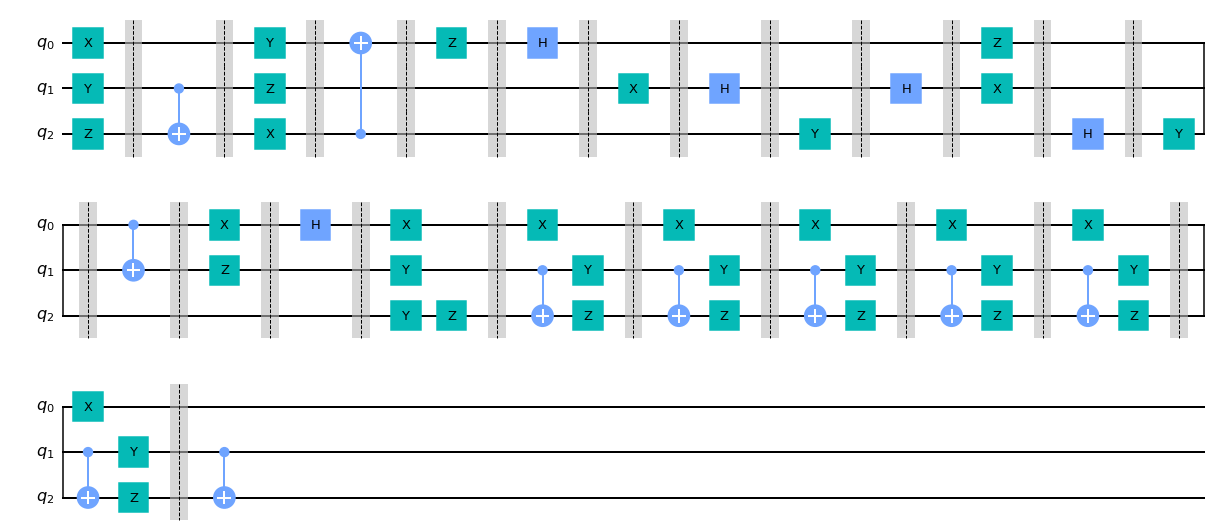

In [5]:
# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.compiler import transpile
from qiskit.circuit.library import QFT

target = QuantumCircuit(3)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.barrier()
target.y(0)
target.z(1)
target.x(2)
target.barrier()
target.cx(2, 0)
target.barrier()
target.z(0)
target.barrier()
target.h(0)
target.barrier()
target.x(1)
target.barrier()
target.h(1)
target.barrier()
target.y(2)
target.barrier()
target.h(1)
target.barrier()
target.z(0)
target.x(1)
target.barrier()
target.h(2)
target.barrier()
target.y(2)
target.barrier()
target.cx(0, 1)
target.barrier()
target.x(0)
target.z(1)
target.barrier()
target.h(0)
target.barrier()
target.y(2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cx(1, 2)

print(Statevector.from_instruction(target))

# target = transpile(target, basis_gates=['id', 'x', 'y', 'z', 'cz', 'h', 't', 'rz'], optimization_level=0)

rc_circs = randomized_circuit(target, 10, 1)

target.draw('mpl')

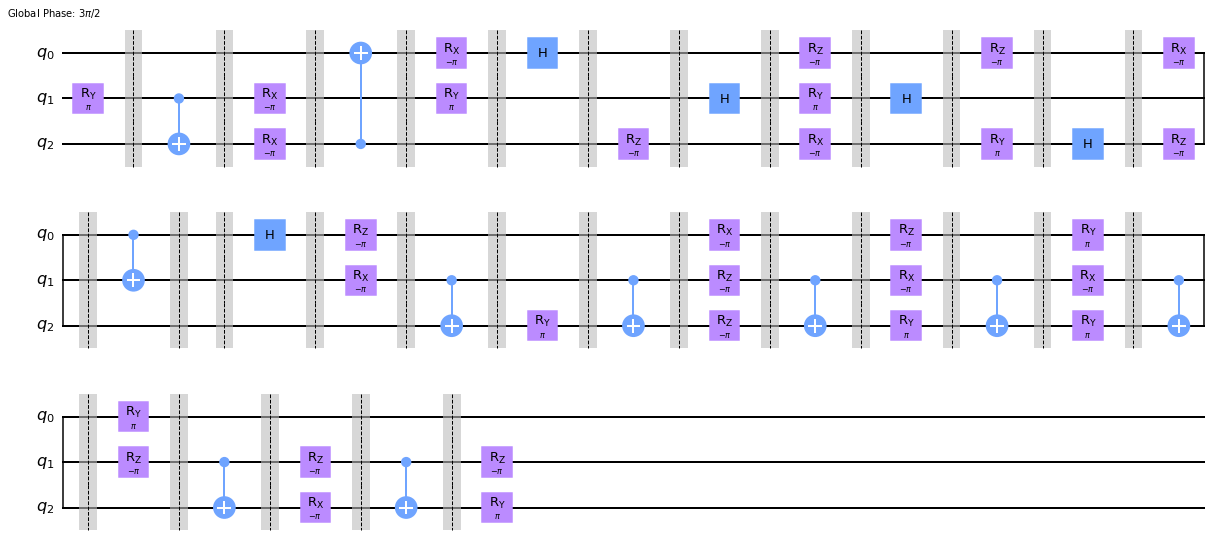

In [6]:
rc_circs[3].draw('mpl')

In [7]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error, coherent_unitary_error
from qiskit.circuit.library import RZGate, RXGate, CXGate

# QuantumError objects
prob = 0.01
angle = 0.1
coherent_err = coherent_unitary_error(CXGate(angle))

# Add errors to noise model
error_model = NoiseModel(basis_gates=['id', 'x', 'y', 'z', 'rx', 'ry', 'rz', 'cz'])
error_model.add_all_qubit_quantum_error(coherent_err, ['cx', 'cz', 'cy'])

backend = AerSimulator(noise_model=error_model)
# backend = FakeParis()

tvd_benchmark_rc_circuit(target, rc_circs, backend=backend, shots_per_randomized_circuit=1000)
# fig = benchmark_rc_circuit(target, rc_circs, measurement_qubits=[0, 1, 2], backend=backend, dpi=200)

[0.30000000000000004,
 [0.0740999999999999,
  0.1232000000000001,
  0.0770999999999999,
  0.026900000000000104,
  0.07289999999999991,
  0.023100000000000107,
  0.07589999999999991,
  0.12680000000000013]]

In [11]:
def tvd_exponential_violin(circuit,n_series,backend,iter_num):
    random_circ_number = []
    tvd_mean_set = []
    tvd_all_set = []
    for iteration in n_series:
        random_circ_number.append(iteration+1)
        temp_tvd = []
        for ind in np.arange(iter_num):
            temp_rc_circuit = randomized_circuit(circuit, iteration+1, 1)
            tvd_value = tvd_benchmark_rc_circuit(circuit, temp_rc_circuit, backend=backend, shots_per_randomized_circuit=1000)
            temp_tvd.append(tvd_value[0])
        tvd_all_set.append(temp_tvd)
        tvd_mean_set.append(np.mean(tvd_all_set[-1]))
    return [random_circ_number,tvd_mean_set,tvd_all_set]

{'bodies': [<matplotlib.collections.PolyCollection at 0x11dd2be0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x11dd2a00>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x288a7880>,
 'cmins': <matplotlib.collections.LineCollection at 0x26ebbfa0>,
 'cbars': <matplotlib.collections.LineCollection at 0x26e3fc70>}

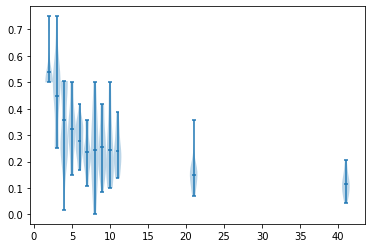

In [15]:
import matplotlib.pyplot as plt
result = tvd_exponential_violin(target,[1,2,3,4,5,6,7,8,9,10,20,40],backend,20)
plt.violinplot(result[2], result[0], points=20, widths=1,showmeans=True)

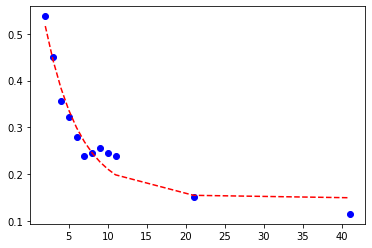

In [16]:
def objective(x, a, b, c):
	return a * np.exp(-c*x) + b
from scipy.optimize import curve_fit
popt, _ = curve_fit(objective, result[0], result[1])
a, b, c = popt
y_line = [objective(res, a, b, c) for res in result[0]] 
plt.plot(result[0], result[1], 'o', color='blue')
plt.plot(result[0], y_line, '--', color='red')
plt.show()


In [22]:
residuals = np.array(result[1])- np.array(y_line)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.array(result[1])-np.array(np.mean(result[1]))**2))
r_squared = 1 - (ss_res / ss_tot)

In [23]:
print(r_squared)

0.9968117286486755
